In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station
print(Measurement)

<class 'sqlalchemy.ext.automap.measurement'>


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
print(session)

# Exploratory Climate Analysis

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


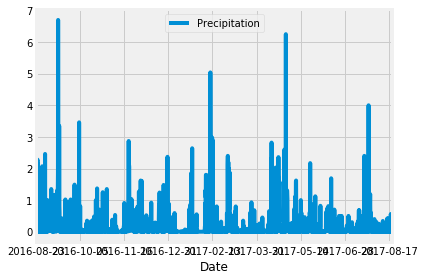

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
inspector = inspect(engine)
inspector.get_table_names()
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

# Calculate the date 1 year ago from the last data point in the database
latdate=session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
latyear=dt.datetime.strptime(latdate,"%Y-%m-%d")-dt.timedelta(days=365)
latyear=str(latyear.date())

# Perform a query to retrieve the data and precipitation scores
latprec=session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=latyear).all()
# print(latprec)

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation=pd.DataFrame(latprec,columns=['Date','Precipitation'])
precipitation.set_index('Date',inplace=True)

# Sort the dataframe by date
precipitation=precipitation.sort_values('Date')
precipitation=precipitation.dropna()
precipitation.head()

# Use Pandas Plotting with Matplotlib to plot the data
precipitation.plot()
plt.legend(loc='upper center')
plt.tight_layout()
plt.savefig("precipitation.png")
plt.show()

![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
station=session.query(Station.station).distinct().count()
print(station)

9


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations=pd.DataFrame(session.query(Measurement.station).all())
stations.station.value_counts().sort_values(ascending=False)

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: station, dtype: int64

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
mintemp=session.query(func.min(Measurement.tobs)).all()
print(mintemp[0][0])
maxtemp=session.query(func.max(Measurement.tobs)).all()
print(maxtemp[0][0])
avgtemp=session.query(func.avg(Measurement.tobs)).all()
print(avgtemp[0][0])

53.0
87.0
73.09795396419437


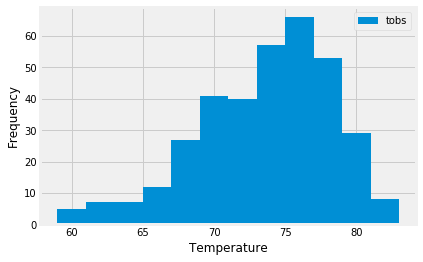

In [15]:
# Choose the station with the highest number of temperature observations.
stationlist=pd.DataFrame(stations.station.value_counts().sort_values(ascending=False))
highstation=stationlist.index.to_numpy()[0]
# higstation=session.query(Measurement.station).order_by(Measurement.tobs.desc()).first()[0]
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
lattobs=session.query(Measurement.tobs).filter(Measurement.date>=latyear,Measurement.station==highstation).all()
lattobs=pd.DataFrame(lattobs,columns=['tobs'])
lattobs.plot.hist(bins=12)
plt.xlabel("Temperature")
plt.savefig("temperature.png")
plt.show()

![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
mytrip=calc_temps('2017-07-01', '2017-07-08')
print (mytrip)

[(71.0, 78.04347826086956, 87.0)]


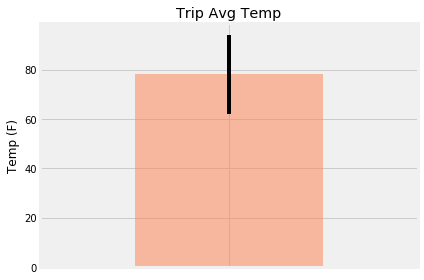

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

min_temp=mytrip[0][0]
avg_temp=mytrip[0][1]
max_temp=mytrip[0][2]

trip_data=pd.DataFrame(mytrip,columns=['min_temp','avg_temp','max_temp'])
trip_data.plot.bar(y='avg_temp',yerr=trip_data.max_temp-trip_data.min_temp,color='coral',alpha=0.5, legend=False)
plt.title("Trip Avg Temp")
plt.xlabel("")
plt.ylabel("Temp (F)")
plt.tight_layout()

# hide x-axis
plt.gca().axes.xaxis.set_ticklabels([]) 

# Save the figure and show
plt.tight_layout()
plt.savefig('trip_temperature.png')
plt.show()

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def calc_prec(start_date, end_date):
 
    return session.query(Measurement.station,Station.name,Station.latitude,Station.longitude,Measurement.prcp).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
        filter(Measurement.station==Station.station).group_by(Measurement.station).\
        order_by(Measurement.prcp.desc()).all()

# function usage example
print(calc_prec('2017-07-01', '2017-07-08'))

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 0.1), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 0.08), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 0.06), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 0.02), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, None), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, None), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, None)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


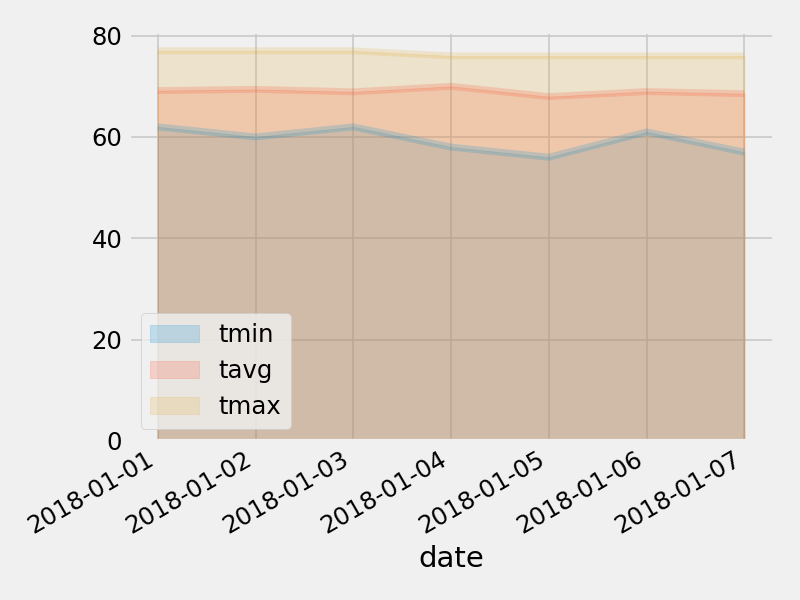

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
